# Meta-Reinforcement Learning with MAML

In this assignment notebook, we will implement **Model-Agnostic Meta-Learning (MAML)** from scratch for a custom `HalfCheetahBackward` environment. The goal is to learn policy parameters that can quickly adapt to new tasks in this case, running the HalfCheetah agent **backward** with just a few gradient steps. Each section below provides context and key steps.

In [1]:
!pip -q install gymnasium[mujoco]
!pip install imageio -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 74.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.5/243.5 kB 23.3 MB/s eta 0:00:00


## Environment & Dependencies


In [2]:
import gymnasium as gym
import random
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
from collections import namedtuple, deque
import imageio
from copy import deepcopy
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal
from torch.distributions import Categorical

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')


This is necessary for running the HalfCheetah env on colab.

In [3]:
%env MUJOCO_GL=egl

env: MUJOCO_GL=egl


This code displays a saved mp4 file.

In [4]:
from IPython.display import HTML
from base64 import b64encode

def show_video(path):
    mp4 = open(path, 'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    return HTML("""
    <video width=400 controls>
          <source src="%s" type="video/mp4">
    </video>
    """ % data_url)

Run this code to get started with the HalfCheetah environment.

In [5]:
env = gym.make("HalfCheetah-v5", render_mode="rgb_array")
env.reset()
frames = []

for _ in range(100):
    frames.append(env.render())
    action = env.action_space.sample()  # random exploratory action
    obs, reward, terminated, truncated, info = env.step(action)  # take a step
    if terminated or truncated:
        env.reset()  # reset if episode ends early

env.close()
imageio.mimsave('./HalfCheetah.mp4', frames, fps=20)
show_video('./HalfCheetah.mp4')


We modify the HalfCheetah environment by creating a wrapper on top it to reward the model for moving backwards.

In [13]:
class HalfCheetahBackward(gym.Env):
    def __init__(self):
        super().__init__()
        self.env = gym.make("HalfCheetah-v5", render_mode="rgb_array")
        self.forward_reward_weight = 1.0
        self.ctrl_cost_weight = 0.05

        # ✅ forward spaces so callers can read dims
        self.action_space = self.env.action_space
        self.observation_space = self.env.observation_space

    def reset(self, *, seed=None, options=None):
        return self.env.reset(seed=seed, options=options)[0]

    def step(self, action):
        obs, _, done, tr, info = self.env.step(action)
        reward = -1 * self.forward_reward_weight * info["reward_forward"] + self.ctrl_cost_weight * info["reward_ctrl"]
        return obs, reward, done, tr, info

    def render(self):
        return self.env.render()

    def close(self):
        self.env.close()


## Gaussian Policy Network
We parameterize our policy π_θ(a|s) as a multivariate Gaussian:
\[
$μ_θ(s) = f_θ(s), \quad Σ_θ = \text{diag}(\exp(2φ))$
\]
Here, `mean_head` outputs μ_θ(s) and `log_std` (φ) is a learned vector of log-standard deviations. Sampling and computing log-probabilities from this distribution is essential for the policy gradient update.

In [14]:
class Policy(nn.Module):
    def __init__(self, obs_dim, act_dim, hidden_sizes=(64,64)):
        super().__init__()
        # MLP feature extractor
        layers = []
        in_dim = obs_dim
        for h in hidden_sizes:
            layers += [nn.Linear(in_dim, h), nn.Tanh()]
            in_dim = h
        self.net = nn.Sequential(*layers)

        # Mean head for μ_θ(s)
        self.mean_head = nn.Linear(in_dim, act_dim)

        # Log-std φ (state-independent)
        self.log_std = nn.Parameter(torch.zeros(act_dim))

    def forward(self, x):
        h = self.net(x)
        mean = self.mean_head(h)
        std = torch.exp(self.log_std)  # broadcast over batch
        return mean, std

    def get_action(self, obs):
        mean, std = self(obs)
        # Diagonal multivariate Gaussian
        dist = torch.distributions.Independent(Normal(mean, std), 1)
        action = dist.sample()  # use rsample() if you need reparameterization
        return action, dist


## Trajectory Collection & Return Computation
The `rollout` function runs the policy in the environment for up to `max_steps`, storing:
- Observations **s_t**
- Actions **a_t** sampled from π_θ
- Log-probabilities **log π_θ(a_t|s_t)**
- Rewards **r_t**
After the episode, we compute discounted returns:
\[
$G_t = \sum_{k=0}^{T-t} γ^k r_{t+k}$
\]
These returns serve as our baselines for policy gradient estimation.

In [16]:
def rollout(env, policy, max_steps=200, gamma=0.99):
    out = env.reset()
    obs = out[0] if isinstance(out, tuple) else out

    obs_buf, logp_buf, rewards = [], [], []

    for _ in range(max_steps):
        obs_t = torch.as_tensor(obs, dtype=torch.float32)
        action, dist = policy.get_action(obs_t)      # keep graph
        logp = dist.log_prob(action)                 # keep graph

        action_np = np.clip(action.cpu().numpy(), env.action_space.low, env.action_space.high)
        step_out = env.step(action_np)
        if len(step_out) == 5:
            next_obs, reward, terminated, truncated, _ = step_out
            done = terminated or truncated
        else:
            next_obs, reward, done, _ = step_out

        obs_buf.append(obs_t)
        logp_buf.append(logp)
        rewards.append(float(reward))

        obs = next_obs
        if done:
            break

    # discounted returns
    returns, G = [], 0.0
    for r in reversed(rewards):
        G = r + gamma * G
        returns.append(G)
    returns.reverse()

    ret_buf = torch.tensor(returns, dtype=torch.float32)
    obs_buf = torch.stack(obs_buf) if obs_buf else torch.empty((0,))
    logp_buf = torch.stack(logp_buf) if logp_buf else torch.empty((0,))

    return obs_buf, logp_buf, ret_buf


Complete this section to evaluate the model and save a sample trajectory.

In [17]:
def evaluate(model, env, num_episodes=10, max_episode_len=200, path="./Final_Evaluation.mp4", no_video=False):
    frames = []
    ep_returns = []

    for episode in range(num_episodes):
        out = env.reset()
        obs = out[0] if isinstance(out, tuple) else out
        total_reward = 0.0

        for t in range(max_episode_len):
            # Record only the first episode for video (if requested)
            if not no_video and episode == 0:
                frames.append(env.render())

            obs_t = torch.as_tensor(obs, dtype=torch.float32)
            with torch.no_grad():
                mean, _ = model(obs_t)
                action = mean  # deterministic action for evaluation

            # Ensure valid action bounds
            action_np = action.cpu().numpy()
            if hasattr(env, "action_space"):
                action_np = np.clip(action_np, env.action_space.low, env.action_space.high)

            step_out = env.step(action_np)
            if len(step_out) == 5:
                obs, reward, terminated, truncated, info = step_out
                done = terminated or truncated
            else:
                obs, reward, done, info = step_out

            total_reward += float(reward)
            if done:
                break

        ep_returns.append(total_reward)

    mean_rewards = float(np.mean(ep_returns)) if ep_returns else 0.0
    print(f"Mean Reward: {mean_rewards:.3f}")

    if not no_video and frames:
        imageio.mimsave(path, frames, fps=20)

    env.close()


## Model-Agnostic Meta-Learning (MAML)
MAML seeks initial parameters $\theta$ that can adapt to a new task with only a few gradient steps. For each task Tᵢ, we perform an **inner loop** update:

\[
$\theta'_i = \theta - α \nabla_\theta \mathcal{L}_{T_i}(\theta)$
\]

Then, the **meta-objective** (outer loop) minimizes the post-adaptation loss (optimize for the initial parameter $\theta$):

\[
$\min_\theta \sum_i \mathcal{L}_{T_i}(\theta'_i) = \sum_i \mathcal{L}_{T_i}\bigl(\theta - α \nabla_\theta \mathcal{L}_{T_i}(\theta)\bigr)$
\]


In [18]:
from copy import deepcopy
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Normal
from torch.nn.utils.stateless import functional_call

class MAML:
    def __init__(
        self,
        task_env_cls,
        inner_lr,
        outer_lr,
        inner_steps,
        meta_batch_size,
        max_episode_len=200,
        gamma=0.99
    ):
        self.task_env_cls   = task_env_cls
        self.inner_lr       = inner_lr
        self.inner_steps    = inner_steps
        self.meta_batch_size= meta_batch_size
        self.max_episode_len= max_episode_len
        self.gamma          = gamma
        self.loss_history   = []
        self.reward_history = []

        # Infer obs/act dimensions from a temp env
        tmp_env = self.task_env_cls()
        obs_dim = tmp_env.observation_space.shape[0]     # TODO
        act_dim = tmp_env.action_space.shape[0]          # TODO
        tmp_env.close()

        # Meta-policy & optimizer
        self.meta_policy = Policy(obs_dim, act_dim)      # TODO
        self.meta_opt    = optim.Adam(                   # TODO Use weight_decay
            self.meta_policy.parameters(), lr=outer_lr, weight_decay=1e-4
        )

    def inner_update(self, env):
        # Collect a support trajectory with current meta policy
        obs_s, logp_s, ret_s = rollout(env, self.meta_policy, max_steps=self.max_episode_len, gamma=self.gamma)  # TODO

        # Policy gradient loss on support: J = E[ G_t * log π(a|s) ]
        # We minimize -J
        pg_loss = -(logp_s * ret_s).mean()  # TODO

        # L2 regularization on parameters
        l2_reg  = 1e-3                                   # TODO Define L2 normalization coef
        l2_loss = sum((p**2).sum() for p in self.meta_policy.parameters())  # TODO Calculate L2 Norm

        loss_s = pg_loss + l2_reg * l2_loss

        # Compute grads w.r.t. meta-parameters; keep graph for higher-order grads
        grads = torch.autograd.grad(loss_s, self.meta_policy.parameters(), create_graph=True)
        return grads

    def adapt_policy(self, grads):
        # Create "stateless" adapted parameters: θ' = θ - α * ∇θ L_support
        named_params = dict(self.meta_policy.named_parameters())
        updated_params = {
            name: param - self.inner_lr * g
            for (name, param), g in zip(named_params.items(), grads)
        }

        # Wrap a stateless view that uses functional_call with updated_params
        class AdaptedPolicy(nn.Module):
            def __init__(self, base, params):
                super().__init__()
                self.base = base
                self.params = params

            def forward(self, x):
                return functional_call(self.base, self.params, (x,))

            def get_action(self, obs):
                mean, std = self(obs)
                dist = torch.distributions.Independent(Normal(mean, std), 1)
                action = dist.sample()
                return action, dist

        adapted = AdaptedPolicy(self.meta_policy, updated_params)  # TODO create a copy of the model and update its weights
        return adapted

    def meta_step(self):
        total_meta_loss = 0.0
        total_reward = 0.0

        for _ in range(self.meta_batch_size):
            env = self.task_env_cls()

            # 1) Inner update on support data
            grads = self.inner_update(env)

            # 2) Build adapted policy θ'
            adapted = self.adapt_policy(grads)  # TODO Get adapted policy (use grads to update weights)

            # 3) Query rollout using adapted policy
            obs_q, logp_q, ret_q = rollout(env, adapted, max_steps=self.max_episode_len, gamma=self.gamma)  # TODO

            # 4) Meta loss: evaluate query loss under adapted params
            loss_q = -(logp_q * ret_q).mean()  # TODO Calculate Meta Loss
            total_meta_loss += loss_q

            total_reward += ret_q.mean().item()

            env.close()

        meta_loss = total_meta_loss / self.meta_batch_size
        self.meta_opt.zero_grad()
        meta_loss.backward()
        self.meta_opt.step()

        self.loss_history.append(meta_loss.item())
        self.reward_history.append(total_reward / self.meta_batch_size)

        return meta_loss.item()

    def train(self, meta_iters=501):
        for it in tqdm(range(1, meta_iters)):
            loss = self.meta_step()
            if it % 10 == 0:
                print(f"\t[Iter {it}]\tloss={loss:.3f},\treward={self.reward_history[-1]:.3f}")
        self.plot_metrics()
        return self.meta_policy

    def plot_metrics(self):
        iters = range(1, len(self.loss_history) + 1)

        plt.figure()
        plt.plot(iters, self.loss_history, label="Loss")
        plt.plot(iters, self.reward_history, label="Avg Query Reward")
        plt.xlabel("Iteration")
        plt.legend()
        plt.title("Training Progress")
        plt.show()


## Training Loop
The `train()` function instantiates the `MAML` class with hyperparameters and executes the meta-training.

In [19]:
def train(inner_lr, outer_lr, inner_steps, meta_batch_size, max_episode_len, gamma=0.99):
    maml = MAML(
        task_env_cls=HalfCheetahBackward,
        inner_lr=inner_lr,
        outer_lr=outer_lr,
        inner_steps=inner_steps,
        meta_batch_size=meta_batch_size,
        max_episode_len=max_episode_len,
        gamma=gamma
    )
    meta_policy = maml.train(meta_iters=500)
    return meta_policy

  0%|          | 0/499 [00:00<?, ?it/s]/tmp/ipython-input-84866080.py:74: FutureWarning: `torch.nn.utils.stateless.functional_call` is deprecated as of PyTorch 2.0 and will be removed in a future version of PyTorch. Please use `torch.func.functional_call` instead which is a drop-in replacement.
  return functional_call(self.base, self.params, (x,))
  2%|▏         | 10/499 [00:31<25:10,  3.09s/it]

	[Iter 10]	loss=123.293,	reward=14.819


  4%|▍         | 20/499 [01:01<23:18,  2.92s/it]

	[Iter 20]	loss=41.943,	reward=4.997


  6%|▌         | 30/499 [01:32<23:39,  3.03s/it]

	[Iter 30]	loss=10.163,	reward=0.832


  8%|▊         | 40/499 [02:01<22:09,  2.90s/it]

	[Iter 40]	loss=95.613,	reward=13.477


 10%|█         | 50/499 [02:32<22:58,  3.07s/it]

	[Iter 50]	loss=18.078,	reward=2.294


 12%|█▏        | 60/499 [03:01<21:16,  2.91s/it]

	[Iter 60]	loss=-47.487,	reward=-5.487


 14%|█▍        | 70/499 [03:31<21:35,  3.02s/it]

	[Iter 70]	loss=58.948,	reward=7.207


 16%|█▌        | 80/499 [04:01<20:57,  3.00s/it]

	[Iter 80]	loss=39.837,	reward=4.750


 18%|█▊        | 90/499 [04:33<21:25,  3.14s/it]

	[Iter 90]	loss=101.416,	reward=11.675


 20%|██        | 100/499 [05:03<19:50,  2.98s/it]

	[Iter 100]	loss=63.214,	reward=7.236


 22%|██▏       | 110/499 [05:34<19:42,  3.04s/it]

	[Iter 110]	loss=55.775,	reward=7.163


 24%|██▍       | 120/499 [06:05<19:11,  3.04s/it]

	[Iter 120]	loss=92.220,	reward=11.188


 26%|██▌       | 130/499 [06:35<18:48,  3.06s/it]

	[Iter 130]	loss=88.309,	reward=10.561


 28%|██▊       | 140/499 [07:05<17:57,  3.00s/it]

	[Iter 140]	loss=-2.682,	reward=-0.483


 30%|███       | 150/499 [07:35<17:35,  3.02s/it]

	[Iter 150]	loss=138.262,	reward=16.878


 32%|███▏      | 160/499 [08:06<17:32,  3.10s/it]

	[Iter 160]	loss=91.468,	reward=11.871


 34%|███▍      | 170/499 [08:37<16:46,  3.06s/it]

	[Iter 170]	loss=115.721,	reward=13.022


 36%|███▌      | 180/499 [09:07<15:58,  3.00s/it]

	[Iter 180]	loss=-31.403,	reward=-3.943


 38%|███▊      | 190/499 [09:37<15:29,  3.01s/it]

	[Iter 190]	loss=-18.490,	reward=-2.290


 40%|████      | 200/499 [10:07<14:33,  2.92s/it]

	[Iter 200]	loss=49.453,	reward=5.958


 42%|████▏     | 210/499 [10:36<14:07,  2.93s/it]

	[Iter 210]	loss=174.481,	reward=20.779


 44%|████▍     | 220/499 [11:06<13:29,  2.90s/it]

	[Iter 220]	loss=-10.294,	reward=-0.671


 46%|████▌     | 230/499 [11:36<13:31,  3.02s/it]

	[Iter 230]	loss=43.488,	reward=5.528


 48%|████▊     | 240/499 [12:06<13:09,  3.05s/it]

	[Iter 240]	loss=14.904,	reward=1.990


 50%|█████     | 250/499 [12:36<12:26,  3.00s/it]

	[Iter 250]	loss=-45.889,	reward=-5.459


 52%|█████▏    | 260/499 [13:05<11:31,  2.89s/it]

	[Iter 260]	loss=12.737,	reward=1.429


 54%|█████▍    | 270/499 [13:34<11:17,  2.96s/it]

	[Iter 270]	loss=0.059,	reward=-0.292


 56%|█████▌    | 280/499 [14:03<10:32,  2.89s/it]

	[Iter 280]	loss=24.000,	reward=3.262


 58%|█████▊    | 290/499 [14:33<10:33,  3.03s/it]

	[Iter 290]	loss=27.739,	reward=3.664


 60%|██████    | 300/499 [15:03<10:15,  3.09s/it]

	[Iter 300]	loss=-11.795,	reward=-1.341


 62%|██████▏   | 310/499 [15:35<10:13,  3.25s/it]

	[Iter 310]	loss=173.398,	reward=20.293


 64%|██████▍   | 320/499 [16:06<09:26,  3.17s/it]

	[Iter 320]	loss=93.830,	reward=11.650


 66%|██████▌   | 330/499 [16:38<08:59,  3.19s/it]

	[Iter 330]	loss=76.867,	reward=9.224


 68%|██████▊   | 340/499 [17:09<08:07,  3.06s/it]

	[Iter 340]	loss=26.359,	reward=3.846


 70%|███████   | 350/499 [17:40<07:43,  3.11s/it]

	[Iter 350]	loss=-10.804,	reward=-0.838


 72%|███████▏  | 360/499 [18:11<07:22,  3.18s/it]

	[Iter 360]	loss=69.357,	reward=7.984


 74%|███████▍  | 370/499 [18:42<06:28,  3.01s/it]

	[Iter 370]	loss=88.763,	reward=11.367


 76%|███████▌  | 380/499 [19:14<06:16,  3.17s/it]

	[Iter 380]	loss=1.994,	reward=0.232


 78%|███████▊  | 390/499 [19:45<05:25,  2.98s/it]

	[Iter 390]	loss=59.194,	reward=7.875


 80%|████████  | 400/499 [20:16<05:02,  3.06s/it]

	[Iter 400]	loss=-27.240,	reward=-3.739


 82%|████████▏ | 410/499 [20:46<04:22,  2.95s/it]

	[Iter 410]	loss=-8.254,	reward=-0.719


 84%|████████▍ | 420/499 [21:16<03:58,  3.02s/it]

	[Iter 420]	loss=73.376,	reward=9.195


 86%|████████▌ | 430/499 [21:46<03:22,  2.93s/it]

	[Iter 430]	loss=81.658,	reward=9.357


 88%|████████▊ | 440/499 [22:16<02:57,  3.01s/it]

	[Iter 440]	loss=198.377,	reward=24.384


 90%|█████████ | 450/499 [22:45<02:22,  2.91s/it]

	[Iter 450]	loss=-59.106,	reward=-6.680


 92%|█████████▏| 460/499 [23:18<02:06,  3.24s/it]

	[Iter 460]	loss=81.613,	reward=9.125


 94%|█████████▍| 470/499 [23:49<01:31,  3.17s/it]

	[Iter 470]	loss=67.978,	reward=8.714


 96%|█████████▌| 480/499 [24:19<00:56,  2.95s/it]

	[Iter 480]	loss=211.236,	reward=25.150


 98%|█████████▊| 490/499 [24:49<00:27,  3.10s/it]

	[Iter 490]	loss=56.694,	reward=7.037


100%|██████████| 499/499 [25:16<00:00,  3.04s/it]


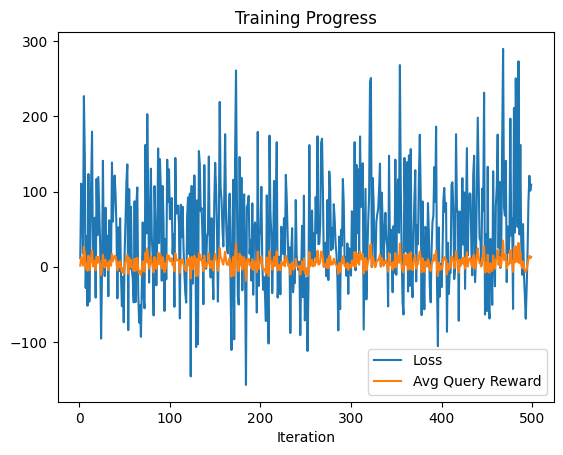

In [20]:
policy = train(
    inner_lr=0.1,
    outer_lr=3e-4,
    inner_steps=1,
    meta_batch_size=5,
    max_episode_len=200,
)


In [21]:
env = HalfCheetahBackward()
evaluate(policy, env, num_episodes=10)

Mean Reward: -68.745


In [22]:
show_video('./Final_Evaluation.mp4')